<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/10_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot] hdbscan kneed

In [10]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml, load_iris
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import umap
import umap.plot as uplot

from kneed import KneeLocator

import hdbscan
from hdbscan.validity import validity_index

sns.set_theme()

### mnist dataset

In [3]:
mnist = fetch_openml('mnist_784', parser='auto')

digits_data = mnist.data/255 # DataFrame
digit_labels = mnist.target

digit_labels_df = pd.DataFrame(digit_labels)
label_subset_df = digit_labels_df.groupby('class').head(2000)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

<ipython-input-3-cd0e7a740970>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_subset_df = digit_labels_df.groupby('class').head(2000)


Number of PCA components 784


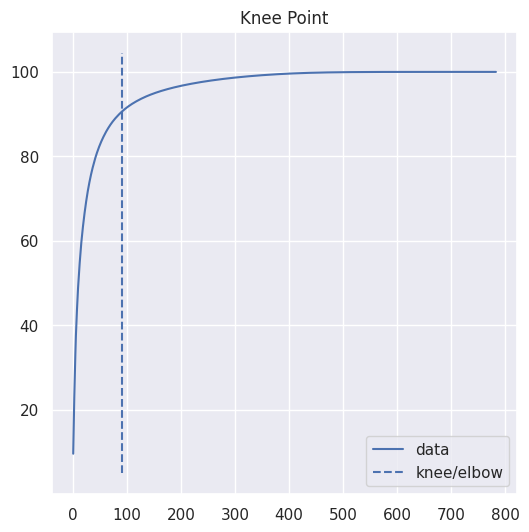

In [4]:
pca = PCA()
pca.fit(digits_data)
pca_transformed_data = pca.transform(digits_data)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    S=1.0,
    curve="concave",
    direction="increasing"
)
kneedle.plot_knee()

In [5]:
pca_dim_red = pca_transformed_data[:,:50]

<Axes: >

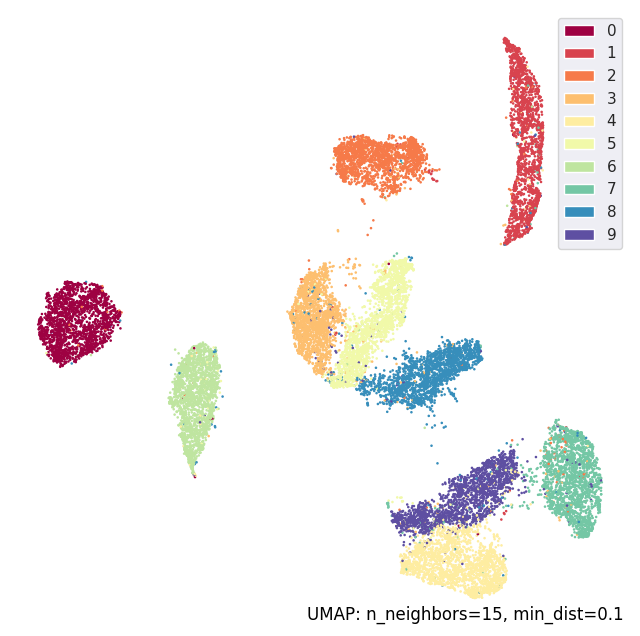

In [6]:
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_dim_red)

uplot.points(umap_obj, labels=digit_labels)

In [7]:
def print_clustering_stats(clusterer, clust_data, data_labels):
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    clust_labels_sub = data_labels[non_noise_idx]
    clust_data_sub = clust_data[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, clust_labels_sub)))
    print('noise size : {}'.format(noise_size))
    print('DBCV : {}'.format(validity_index(clust_data, np_labels)))

ARI : 0.0620451604091957
ARI sub : 0.9949149740514572
noise size : 14873
DBCV : 0.0275406710127663


<Axes: >

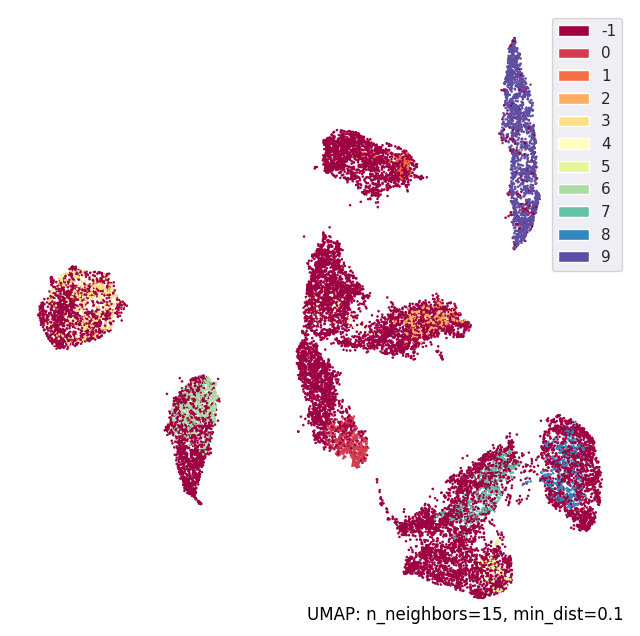

In [10]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=100,
    metric='euclidean'
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=clusterer.labels_)

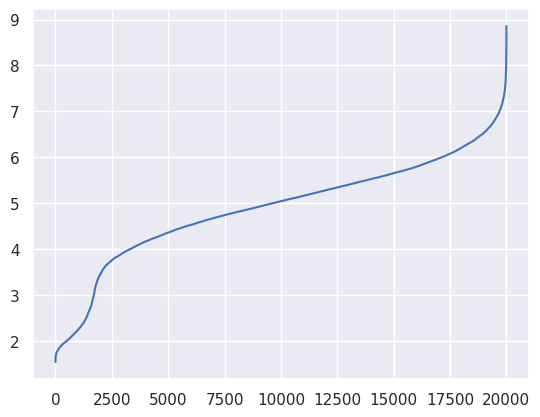

In [12]:
min_pts = 50

knn = NearestNeighbors(n_neighbors=min_pts+1)
knn.fit(pca_dim_red)
distances, _ = knn.kneighbors(pca_dim_red)

sort_dist = np.sort(distances[:,-1])

plt.plot(range(sort_dist.shape[0]), sort_dist)

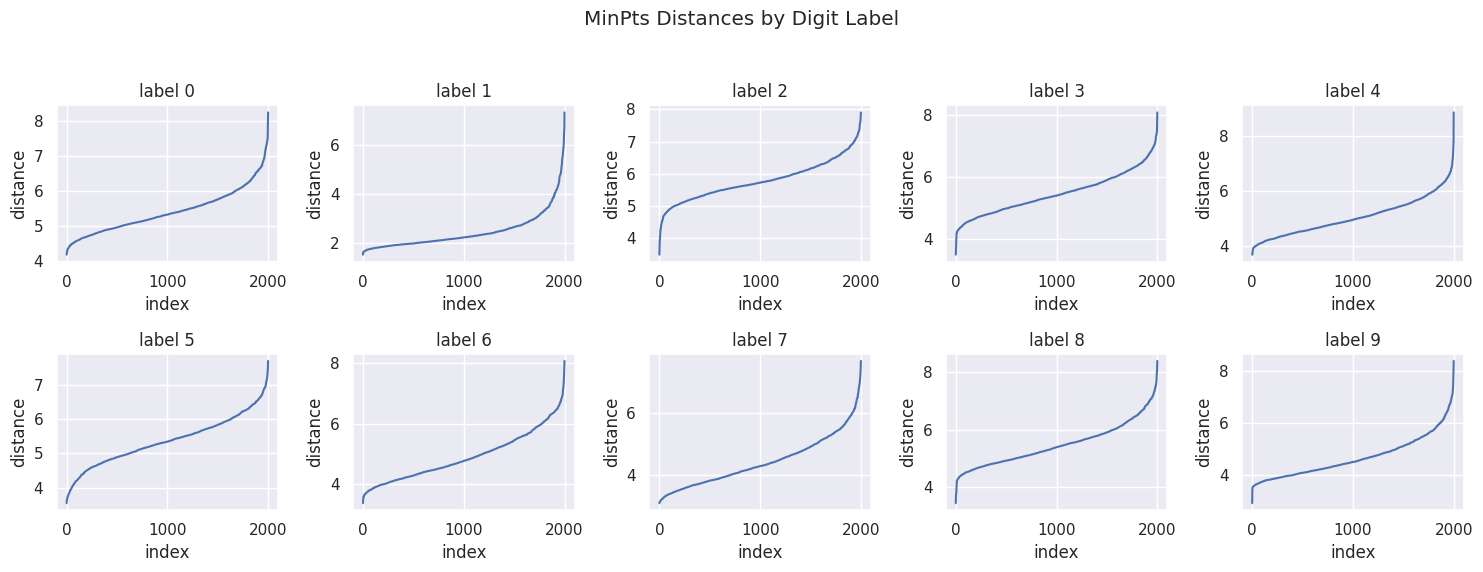

In [ ]:
distances_min_pts = distances[:, -1]

distances_by_label = {label: [] for label in np.unique(digit_labels)}
for i, label in enumerate(digit_labels):
    distances_by_label[label].append(distances_min_pts[i])

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle('MinPts Distances by Digit Label')
for label, ax in zip(distances_by_label.keys(), axes.flatten()):
    sort_dist = np.sort(distances_by_label[label])
    ax.plot(range(sort_dist.shape[0]), sort_dist)

    ax.set_title(f'label {label}')
    ax.set_xlabel('index')
    ax.set_ylabel('distance')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
def print_clustering_stats2(clusterer, clust_data, data_labels):
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    clust_labels_sub = data_labels[non_noise_idx]
    clust_data_sub = clust_data[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, clust_labels_sub)))
    print('noise size : {}'.format(noise_size))

ARI : 0.015190023771268329
ARI sub : 0.0014102175332061382
noise size : 3629


<Axes: >

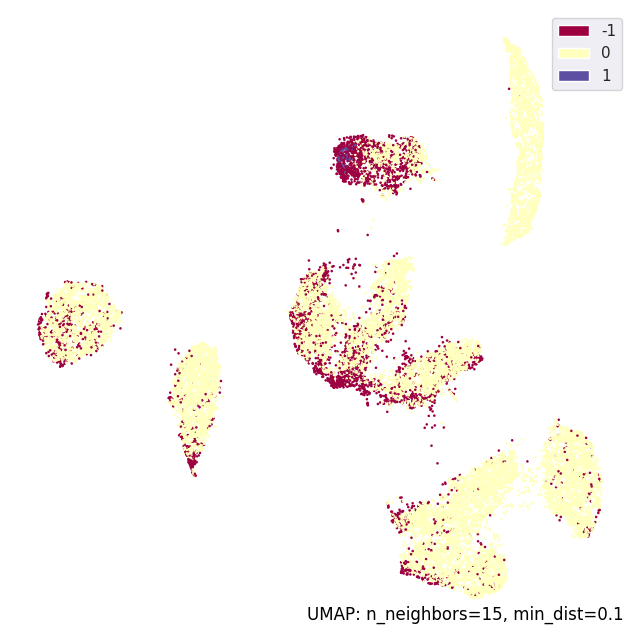

In [15]:
dbscan_tun = DBSCAN(eps=5, min_samples=min_pts)
_ = dbscan_tun.fit(pca_dim_red)

print_clustering_stats2(
    clusterer=dbscan_tun,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=dbscan_tun.labels_)